# Data Pipelines

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/AI_4_Climate_Bootcamp/blob/main/Week 03 - Introduction to Computer Vision/4. Data Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

TensorFlow data pipelines are a powerful tool that can simplify and optimize the process of data preparation, batching and loading for your machine learning models, particularly in the field of computer vision.

In computer vision tasks, data preparation can be a time-consuming and memory-intensive process. The images used for training and validation are often very large in size and need to be preprocessed, resized and transformed into a format suitable for the model. The TensorFlow data pipeline helps automate these steps and makes it easier to use large datasets efficiently.

TensorFlow data pipelines use the `tf.data` module, which provides a flexible and high-performance data pipeline that can handle a variety of data formats. With TensorFlow data pipelines, you can easily load and preprocess large datasets, and batch and shuffle the data for training your model. The pipeline also allows for parallel processing of the data, which can significantly speed up the training process.

In this notebook, we will explore TensorFlow data pipelines in detail, and show you how to use them in your computer vision projects.

Reference: 
- [TensorFlow Data Guide](https://www.tensorflow.org/guide/data) 
- [TensorFlow Image Loading and Preprocessing](https://www.tensorflow.org/tutorials/load_data/images)


## Table of Contents <a name="toc"></a>
* [Example on Dummy Data](#dummy)
* [Data Pipe for Cats vs Dogs](#cats)
  *  [Vanilla CNN Model](#vanilla)
  *  [Transfer Learning ResNet50 Model](#transfer)
* [Image Data Generatora](#generator)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# The libraries below are built-into python and are used to work with local storage and directories
import os

## Example on Dummy Data <a name="dummy"></a>
[Back to Top](#toc)

Let's start by creating a simple dataset of 10 numbers and then build a pipeline to process it. We will use the `tf.data.Dataset.from_tensor_slices()` method to create a dataset from a tensor. This method takes a tensor as input and returns a `tf.data.Dataset` object.

This example is meant to illustrate the basic concepts of TensorFlow data pipelines. In practice, you will usually load your data from files or other sources.

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# create random dataset data using numpy
x = np.random.uniform(low=0, high=1, size=(1000, 5))
# create y using a linear formula with some noise
y = (
    -1 * x[:, 0]
    + 1 * x[:, 1]
    + -1 * x[:, 2]
    + 1 * x[:, 3]
    + -1 * x[:, 4]
    + np.random.normal(loc=0, scale=0.1, size=1000)
)

x.shape, y.shape

((1000, 5), (1000,))

In [4]:
# create train and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.2, random_state=seed
)

In [5]:
# function to create tf.data.Dataset from numpy arrays
def create_dataset(x, y):
    # create tf.data.Dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # shuffle the dataset
    dataset = dataset.shuffle(buffer_size=len(x))
    # batch the dataset
    dataset = dataset.batch(batch_size=8)
    return dataset


# create train and test datasets
train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-03 17:46:04.692598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 17:46:04.692787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# iterate over the dataset, notice that the dataset return batches of data and not single examples
for x_batch, y_batch in train_dataset:
    print(x_batch.shape, y_batch.shape)
    print("Inputs Batch:", x_batch)
    print("Outputs Batch:", y_batch)
    break  # break the loop after the first iteration

(8, 5) (8,)
Inputs Batch: tf.Tensor(
[[0.53157215 0.03265906 0.47559619 0.40774811 0.16121881]
 [0.31577315 0.0568814  0.76652732 0.70210745 0.33135222]
 [0.33424389 0.7709122  0.10659825 0.07513778 0.72818876]
 [0.29335342 0.52547031 0.69783279 0.90026411 0.79219119]
 [0.60754485 0.17052412 0.06505159 0.94888554 0.96563203]
 [0.58064523 0.93593725 0.67225069 0.48127795 0.80967504]
 [0.91985562 0.34634599 0.3469532  0.73750125 0.45221794]
 [0.18527685 0.54127011 0.64557218 0.04558516 0.94597089]], shape=(8, 5), dtype=float64)
Outputs Batch: tf.Tensor(
[-0.78881507 -0.67168966 -0.23385055 -0.4759486  -0.54681815 -0.71925862
 -0.49952118 -1.2057952 ], shape=(8,), dtype=float64)


In [ ]:
# create and train a super simple model
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(5,))])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.MeanAbsoluteError(),
)
model.fit(train_dataset, epochs=100, validation_data=test_dataset)

## Data Pipelines for Cats vs. Dogs Dataset <a name="cats"></a>
[Back to Top](#toc)

Now let's look at a more realistic example. We will use the [Cats vs. Dogs dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). This dataset contains 2,000 images of cats and dogs, split into 1,000 training images and 1,000 validation images. The images are in JPEG format and have different sizes.

Let's download the dataset and take a look at the images. We will notice that the images have different sizes and that the labels are stored in a separate file and folders. The downloaded dataset structure look something like this:

```
cats_vs_dogs_filtered/
    train/
        cats/
            cat0001.jpg
            cat0002.jpg
            ...
        dogs/
            dog0001.jpg
            dog0002.jpg
            ...
    validation/
        cats/
            cat2001.jpg
            cat2002.jpg
            ...
        dogs/
            dog2001.jpg
            dog2002.jpg
            ...
```

Notice how the folder structure splits the images into training and validation sets, and how the images are stored in separate folders for each class. We will use the `os` module to get the list of files and store them as image paths and labels in a list.

In [ ]:
# download and unzip the dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [7]:
# now read the dataset manually using os and put it into a dataframe
# we will create a function to do this so we can reuse it for both the training and validation sets


def read_dataset(path):  # e.g. path = cats_and_dogs_filtered/train
    x = []  # images
    y = []  # labels

    # we will use os.listdir to read the contents of the folder
    labels = os.listdir(path)  # e.g. labels = ["cats", "dogs"]

    # iterate over the labels
    for label in labels:
        # we join the label to the path to get the path to the class folder which contains the images
        label_dir = os.path.join(path, label)  # e.g. cats_and_dogs_filtered/train/cat

        # we will use os.listdir again to read the contents of the class folders (i.e., the images)
        images = os.listdir(label_dir)  # e.g. ["cat.100.jpg", "cat.101.jpg", ...]

        # iterate over the images
        for image in os.listdir(label_dir):
            # we join the image name to the path to get the path to the image
            image_path = os.path.join(
                label_dir, image
            )  # e.g. cats_and_dogs_filtered/train/cats/cat.100.jpg

            # append the image path and the label to the lists
            x.append(image_path)
            y.append(label)

    # return a dataframe with the image paths and labels
    return pd.DataFrame({"image": x, "label": y})


# read the training and validation sets
train_df = read_dataset("cats_and_dogs_filtered/train")
val_df = read_dataset("cats_and_dogs_filtered/validation")

In [8]:
train_df.head()

,image,label
0,cats_and_dogs_filtered/train/dogs/dog.775.jpg,dogs
1,cats_and_dogs_filtered/train/dogs/dog.761.jpg,dogs
2,cats_and_dogs_filtered/train/dogs/dog.991.jpg,dogs
3,cats_and_dogs_filtered/train/dogs/dog.749.jpg,dogs
4,cats_and_dogs_filtered/train/dogs/dog.985.jpg,dogs


Currently the dataset is a piar of iamge paths and labels. We will need to transform the image paths into tensors and resize them to a uniform size. We will also need to convert the labels into integers (0 for cats and 1 for dogs). We don't need to one-hot encode the labels because the classification is binary.

Before creating the dataset, we will create maping functions that will transform the dataset. The `map()` method allows us to apply a function to each element of the dataset. We will use the `map()` method to apply the mapping functions to the dataset.

Note that any map function we create for the purpose of mapping a dataset of input and output pairs (x, y) must take two arguments: x and y and return two values: x and y. The `map()` method will apply the function to each element of the dataset, and the function must be able to handle both the input and the output.

We will now create 3 functions:
    - image_to_tensor: This function will take an image path as input and return the image as a tensor.
    - image_augmentation: This function will take an image tensor as input and return the augmented image tensor.
    - label_encoder: This function will take a label as input and return the encoded label.

In [9]:
def image_to_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = img / 255.0
    return img, y

In [10]:
def image_augmentation(x, y):
    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(x)
    # randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    # randomly change the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    # clip the image to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    return img, y

In [11]:
def label_encoder(x, y):
    if y == "dogs":
        label = 1
    else:
        label = 0

    return x, label

In [15]:
# We will create a function that takes input output pairs and returns a tf.data.Dataset
def dataset_creator(x, y, training=False):
    # create a tf.data.Dataset from the input output pairs
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # map the image paths to tensors
    dataset = dataset.map(image_to_tensor)
    # map the labels to one-hot encoded vectors
    dataset = dataset.map(label_encoder)
    # if training, apply image augmentation. Remember that we never apply image augmentation to the validation set
    if training:
        dataset = dataset.map(image_augmentation)
    # shuffle the dataset
    dataset = dataset.shuffle(1000)
    # batch the dataset
    dataset = dataset.batch(32)

    return dataset


# create the training and validation datasets
train_dataset = dataset_creator(train_df["image"], train_df["label"], training=True)
val_dataset = dataset_creator(val_df["image"], val_df["label"])

(32, 224, 224, 3) (32,)


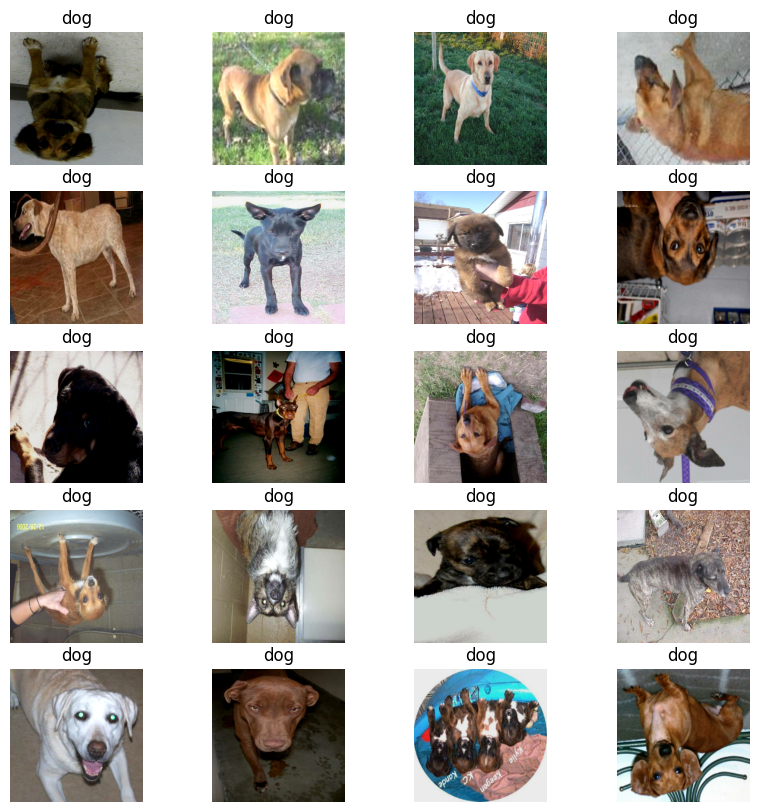

In [16]:
# preview a sample of the images from trian_dataset
for x, y in train_dataset:
    print(x.shape, y.shape)
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.imshow(x[i])
        plt.title("cat" if int(y[i]) == 0 else "dog")
        plt.axis("off")
    plt.show()
    break

### Vanilla CNN Model <a name="vanilla"></a>
[Back to Top](#toc)

Now that we have created the dataset, we can build a simple CNN model to classify the images. We will use the `tf.keras.Sequential` API to build the model. We will use the `tf.keras.layers.Conv2D` layer to add convolutional layers to the model. We will use the `tf.keras.layers.MaxPool2D` layer to add pooling layers to the model. We will use the `tf.keras.layers.Flatten` layer to flatten the output of the last convolutional layer. We will use the `tf.keras.layers.Dense` layer to add fully connected layers to the model.

In [14]:
# Build a CNN model for the task of Cats vs Dogs where there are 2000 training images and 1000 validation images and the image size is 224x224x3, optimize for accuracy and minimize overfitting.

vanilla_cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(224, 224, 3)
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

vanilla_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 111, 111, 32)     0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                        

In [ ]:
# compile
vanilla_cnn_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

# train
vanilla_cnn_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback],
)

### Transfer Learning ResNet50V2 Model <a name="transfer"></a>
[Back to Top](#toc)

We will now use transfer learning to build a more powerful model. We will use a ResNet model as a base model and add a few fully connected layers on top of it. We will freeze the base model and train only the top layers.

In [17]:
# we first need to reprocess the data to apply ResNet50V2 preprocessing instead of our regular one
def image_to_resnet_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, y


def tf_dataset_creator(x, y, training=False):
    # create a tf.data.Dataset from the input output pairs
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # map the image paths to tensors using the new resnet preprocessing function
    dataset = dataset.map(image_to_resnet_tensor)
    # map the labels to one-hot encoded vectors
    dataset = dataset.map(label_encoder)
    # if training, apply image augmentation. Remember that we never apply image augmentation to the validation set
    if training:
        dataset = dataset.map(image_augmentation)
    # shuffle the dataset
    dataset = dataset.shuffle(1000)
    # batch the dataset
    dataset = dataset.batch(32)


# create the training and validation datasets
train_dataset = tf_dataset_creator(train_df["image"], train_df["label"], training=True)
val_dataset = tf_dataset_creator(val_df["image"], val_df["label"])

In [18]:
# load base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

# freeze the base model
base_model.trainable = False

# create a new model on top
transfer_model = tf.keras.Sequential(
    [
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,946,049
Trainable params: 51,381,249
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# compile
transfer_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

# train
transfer_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback],
)

## Image Data Generators <a name="generator"></a>
[Back to Top](#toc)

In the field of computer vision, Image Data Generators are an essential tool for preprocessing image datasets. They provide a convenient and efficient way to augment, resize, and batch images before feeding them into a neural network model.

An Image Data Generator can perform a variety of operations on images, such as:

- Rescaling pixel values to have a standard range
- Rotation, flipping, and zooming images
- Adding random noise to images
- Shifting and shearing images

The Image Data Generator is a part of the TensorFlow library, and is part of the Keras API. It is used in conjunction with the fit method of a model, and allows us to easily preprocess large datasets without having to manually write custom code. This can save a significant amount of time, as well as reducing the risk of bugs and inconsistencies in preprocessing code.

The Image Data Generator is highly customizable, allowing us to specify the exact operations we want to perform on our images, as well as the parameters of these operations. This makes it a versatile and flexible tool for preprocessing image data.

Reference:
- [Image Data Generator](https://keras.io/api/preprocessing/image/)




In [26]:
# we first create a data generator and specify the preprocessing and data augmentation operations

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode="nearest",
)

# we only rescale the validation set, no data augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

In [27]:
# create the data generators from directory
train_generator = train_datagen.flow_from_directory(
    "cats_and_dogs_filtered/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

val_generator = val_datagen.flow_from_directory(
    "cats_and_dogs_filtered/validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# let's display the details of the data generators
print("Image Shape: ", train_generator.image_shape)
print("Train Samples: ", train_generator.samples)
print("Validation Samples: ", val_generator.samples)
print("Output Classes: ", train_generator.class_indices)

Image Shape:  (224, 224, 3)
Train Samples:  2000
Validation Samples:  1000
Output Classes:  {'cats': 0, 'dogs': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(32, 224, 224, 3) (32,)


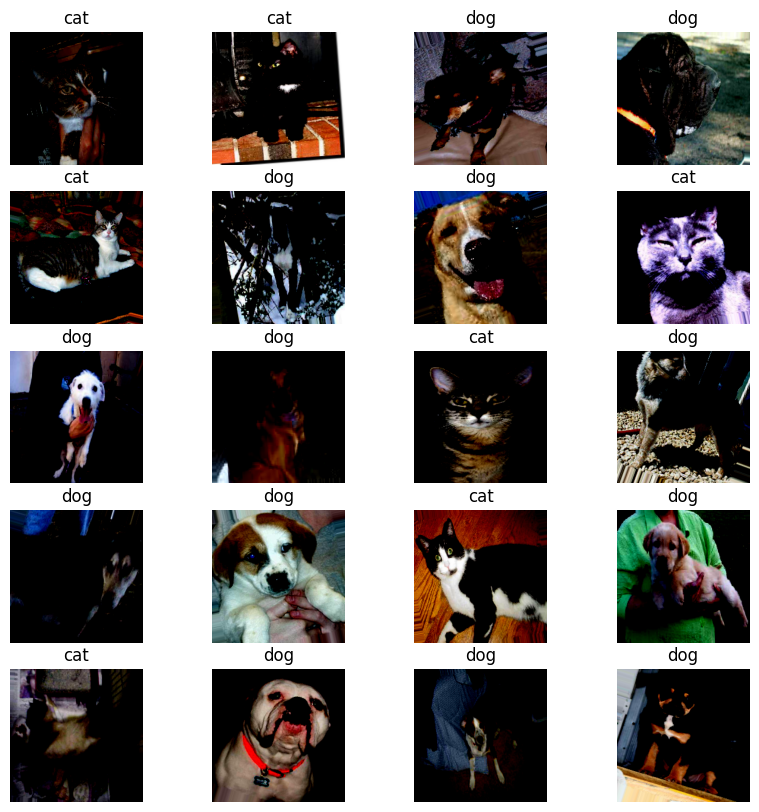

In [29]:
# preview data from generator
for x, y in train_generator:
    print(x.shape, y.shape)
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.imshow(x[i])
        plt.title("cat" if int(y[i]) == 0 else "dog")
        plt.axis("off")
    plt.show()
    break

In [25]:
# load base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

# freeze the base model
base_model.trainable = False

# create a new model on top
transfer_model = tf.keras.Sequential(
    [
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,946,049
Trainable params: 51,381,249
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# compile
transfer_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

# we can fit the model directly on the generators
transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping_callback],
)